In [1]:
import pandas as pd
import numpy as np
from tvDatafeed import TvDatafeed, Interval
import talib
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
tv = TvDatafeed()
df = tv.get_hist(symbol='CCM1!',
                           exchange='BMFBOVESPA',
                           interval=Interval.in_daily, n_bars=1500)

df["Retornos"] = df["close"].pct_change(1)
df.dropna(axis = 0, inplace = True) 
df.tail()

you are using nologin method, data you access may be limited


,symbol,open,high,low,close,volume,Retornos
datetime,,,,,,,
2023-08-07 17:00:00,BMFBOVESPA:CCM1!,55.10,56.00,54.90,55.73,8187.0,0.011985
2023-08-08 17:00:00,BMFBOVESPA:CCM1!,55.73,55.95,55.10,55.15,6307.0,-0.010407
2023-08-09 17:00:00,BMFBOVESPA:CCM1!,55.03,55.29,54.70,54.86,6842.0,-0.005258
2023-08-10 17:00:00,BMFBOVESPA:CCM1!,54.82,54.96,53.16,53.65,12131.0,-0.022056
2023-08-13 17:00:00,BMFBOVESPA:CCM1!,53.61,53.79,53.55,53.61,196.0,-0.000746


In [3]:
milho = pd.read_csv('Milho.csv', sep=",", decimal=",", index_col="Data", parse_dates=True, dayfirst=True)
milho = milho.sort_index(ascending=True)

# Substitua os dados do milho pelo seu dataframe
milho = milho[['Abertura', 'Máxima', 'Mínima', 'Fechamento']]
milho.columns = ['Open', 'High', 'Low', 'Close']

In [4]:
milho['Rentabilidade'] = milho['Close'].pct_change()
milho['Rentabilidade'].fillna(0, inplace=True)
milho['Trix'] = talib.TRIX(milho['Close'], 5).round(2)
milho['Trix_EMA'] = milho['Trix'].rolling(3).mean().round(2)
milho.dropna(inplace=True)

In [5]:
milho.tail(5)

,Open,High,Low,Close,Rentabilidade,Trix,Trix_EMA
Data,,,,,,,
2023-08-07,54.85,55.20,54.35,55.15,0.005286,-0.36,-0.36
2023-08-08,55.10,56.00,54.90,55.75,0.010879,-0.29,-0.34
2023-08-09,55.73,55.95,55.10,55.10,-0.011659,-0.25,-0.30
2023-08-10,55.03,55.29,54.70,54.80,-0.005445,-0.24,-0.26
2023-08-11,54.82,54.96,53.16,53.71,-0.019891,-0.30,-0.26


In [19]:
mask = (milho.index > (pd.to_datetime('today') - pd.DateOffset(years=1)))#years=5
milho_filtered = milho.loc[mask]

In [20]:
def backtest(data, entry_signal, exit_signal, entry_value='Close', exit_value='Close', side='Long', cost = 0):
    trades = []
    position = False
    entry_date = None
    entry_price = None
    
    for index, row in data.iterrows():
        if not position:
            if row[entry_signal]:
                position = True
                entry_date = index
                entry_price = row[entry_value]
        else:
            if row[exit_signal]:
                position = False
                exit_date = index
                exit_price = row[exit_value]
                if side == 'Long':
                    trade_return = ((exit_price - entry_price) / entry_price) - (cost/100)
                elif side == 'Short':
                    trade_return = ((exit_price - entry_price) / entry_price*-1) - (cost/100)
                else:
                    trade_return = np.NAN
                trades.append([side, entry_date, exit_date, entry_price, exit_price, trade_return])
    
    trades_df = pd.DataFrame(trades, columns=['Side', 'Entry Date', 'Exit Date', 'Entry Price', 'Exit Price', 'Return'])
    return trades_df

In [21]:
# Add entry and exit signals as new columns in the milho DataFrame
milho_filtered['LongEntrySignal'] = (milho_filtered['Trix'] > milho_filtered['Trix_EMA']) & (milho_filtered['Trix'].shift() <= milho_filtered['Trix_EMA'].shift())
milho_filtered['LongExitSignal'] = (milho_filtered['Trix'] < milho_filtered['Trix_EMA']) & (milho_filtered['Trix'].shift() >= milho_filtered['Trix_EMA'].shift())
milho_filtered['LongValue'] = milho_filtered['Open'].shift(-1)

milho_filtered['ShortEntrySignal'] = (milho_filtered['Trix'] < milho_filtered['Trix_EMA']) & (milho_filtered['Trix'].shift() >= milho_filtered['Trix_EMA'].shift())
milho_filtered['ShortExitSignal'] = (milho_filtered['Trix'] > milho_filtered['Trix_EMA']) & (milho_filtered['Trix'].shift() <= milho_filtered['Trix_EMA'].shift())
milho_filtered['ShortValue'] = milho_filtered['Open'].shift(-1)


In [22]:
# Run the backtest using the Long signal columns
trades_long_filtered = backtest(milho_filtered, 'LongEntrySignal', 'LongExitSignal', 'LongValue', 'LongValue', 'Long', 0.02)
trades_long_filtered

,Side,Entry Date,Exit Date,Entry Price,Exit Price,Return
0,Long,2022-08-25,2022-09-01,97.98,97.87,-0.001323
1,Long,2022-09-08,2022-09-21,97.99,98.41,0.004086
2,Long,2022-09-30,2022-10-03,99.10,96.95,-0.021895
3,Long,2022-10-11,2022-10-21,95.30,95.21,-0.001144
4,Long,2022-10-27,2022-11-04,95.30,94.34,-0.010273
5,Long,2022-11-17,2022-11-29,94.19,94.63,0.004471
6,Long,2022-12-08,2022-12-26,93.59,94.00,0.004181
7,Long,2022-12-28,2023-01-03,95.42,94.15,-0.013510
8,Long,2023-01-10,2023-01-17,94.64,93.72,-0.009921
9,Long,2023-01-31,2023-02-07,90.74,89.52,-0.013645


In [23]:
# Run the backtest using the Short signal columns
trades_short_filtered = backtest(milho_filtered, 'ShortEntrySignal', 'ShortExitSignal', 'ShortValue', 'ShortValue', 'Short', 0.02)
trades_short_filtered

,Side,Entry Date,Exit Date,Entry Price,Exit Price,Return
0,Short,2022-09-01,2022-09-08,97.87,97.99,-0.001426
1,Short,2022-09-21,2022-09-30,98.41,99.10,-0.007211
2,Short,2022-10-03,2022-10-11,96.95,95.30,0.016819
3,Short,2022-10-21,2022-10-27,95.21,95.30,-0.001145
4,Short,2022-11-04,2022-11-17,94.34,94.19,0.001390
5,Short,2022-11-29,2022-12-08,94.63,93.59,0.010790
6,Short,2022-12-26,2022-12-28,94.00,95.42,-0.015306
7,Short,2023-01-03,2023-01-10,94.15,94.64,-0.005404
8,Short,2023-01-17,2023-01-31,93.72,90.74,0.031597
9,Short,2023-02-07,2023-02-10,89.52,90.84,-0.014945


In [24]:
# Concatenate the trades_long and trades_short DataFrames
trades_filtered = pd.concat([trades_long_filtered, trades_short_filtered], ignore_index=True)

# Drop rows with null values
trades_filtered = trades_filtered.dropna()

# Sort the resulting DataFrame by the 'Entry Date' column
trades_filtered = trades_filtered.sort_values(by='Entry Date')

trades_filtered['CumReturnSimple'] = trades_filtered['Return'].cumsum()
trades_filtered['CumReturnCompound'] = (trades_filtered['Return'] + 1).cumprod() - 1

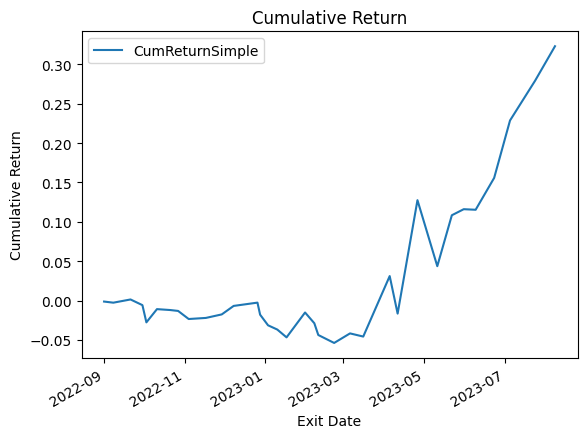

In [25]:
# Investindo mesma quantidade
trades_filtered.plot(x='Exit Date', y='CumReturnSimple')
plt.title('Cumulative Return')
plt.xlabel('Exit Date')
plt.ylabel('Cumulative Return')
plt.show()

In [26]:
# Add entry and exit signals as new columns in the milho DataFrame
milho['LongEntrySignal'] = (milho['Trix'] > milho['Trix_EMA']) & (milho['Trix'].shift() <= milho['Trix_EMA'].shift())
milho['LongExitSignal'] = (milho['Trix'] < milho['Trix_EMA']) & (milho['Trix'].shift() >= milho['Trix_EMA'].shift())
milho['LongValue'] = milho['Open'].shift(-1)

# Add entry and exit signals as new columns in the milho DataFrame
milho['ShortEntrySignal'] = (milho['Trix'] < milho['Trix_EMA']) & (milho['Trix'].shift() >= milho['Trix_EMA'].shift())
milho['ShortExitSignal'] = (milho['Trix'] > milho['Trix_EMA']) & (milho['Trix'].shift() <= milho['Trix_EMA'].shift())
milho['ShortValue'] = milho['Open'].shift(-1)

In [27]:
# Run the backtest using the Long signal columns
trades_long = backtest(milho, 'LongEntrySignal', 'LongExitSignal', 'LongValue', 'LongValue', 'Long', 0.02)
trades_long

,Side,Entry Date,Exit Date,Entry Price,Exit Price,Return
0,Long,2008-10-29,2008-11-07,22.79,21.91,-0.038813
1,Long,2008-11-10,2008-11-21,22.42,23.01,0.026116
2,Long,2008-12-05,2008-12-12,24.06,24.01,-0.002278
3,Long,2008-12-15,2008-12-19,24.89,25.34,0.017880
4,Long,2008-12-26,2009-01-09,27.22,27.88,0.024047
...,...,...,...,...,...,...
257,Long,2023-04-26,2023-05-11,66.56,60.99,-0.083884
258,Long,2023-05-22,2023-05-31,57.03,57.48,0.007691
259,Long,2023-06-09,2023-06-23,57.51,59.85,0.040489
260,Long,2023-07-05,2023-07-24,55.47,58.29,0.050638


In [28]:
# Run the backtest using the Short signal columns
trades_short = backtest(milho, 'ShortEntrySignal', 'ShortExitSignal', 'ShortValue', 'ShortValue', 'Short', 0.02)
trades_short

,Side,Entry Date,Exit Date,Entry Price,Exit Price,Return
0,Short,2008-10-23,2008-10-29,22.68,22.79,-0.005050
1,Short,2008-11-07,2008-11-10,21.91,22.42,-0.023477
2,Short,2008-11-21,2008-12-05,23.01,24.06,-0.045832
3,Short,2008-12-12,2008-12-15,24.01,24.89,-0.036851
4,Short,2008-12-19,2008-12-26,25.34,27.22,-0.074391
...,...,...,...,...,...,...
257,Short,2023-04-11,2023-04-26,77.79,66.56,0.144163
258,Short,2023-05-11,2023-05-22,60.99,57.03,0.064729
259,Short,2023-05-31,2023-06-09,57.48,57.51,-0.000722
260,Short,2023-06-23,2023-07-05,59.85,55.47,0.072983


In [29]:
# Concatenate the trades_long and trades_short DataFrames
trades = pd.concat([trades_long, trades_short], ignore_index=True)

# Drop rows with null values
trades = trades.dropna()

# Sort the resulting DataFrame by the 'Entry Date' column
trades = trades.sort_values(by='Entry Date')

trades['CumReturnSimple'] = trades['Return'].cumsum()
trades['CumReturnCompound'] = (trades['Return'] + 1).cumprod() - 1


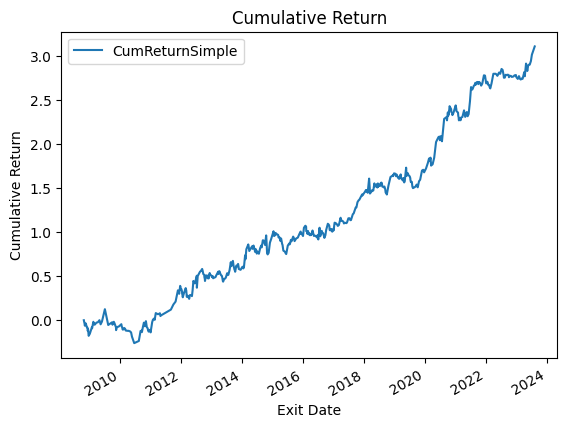

In [30]:
# Investindo mesma quantidade
trades.plot(x='Exit Date', y='CumReturnSimple')
plt.title('Cumulative Return')
plt.xlabel('Exit Date')
plt.ylabel('Cumulative Return')
plt.show()


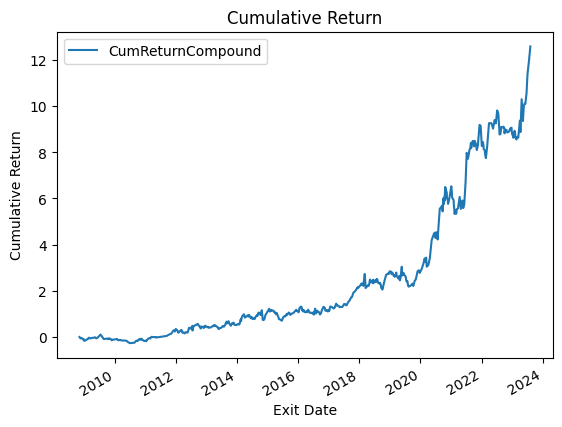

In [31]:
# Reinvestindo os lucros
trades.plot(x='Exit Date', y='CumReturnCompound')
plt.title('Cumulative Return')
plt.xlabel('Exit Date')
plt.ylabel('Cumulative Return')
plt.show()